In [1]:
from deepsudoku import REPO_PATH, DIFFICULTIES
import os
os.chdir(REPO_PATH)

import tensorflow as tf
import numpy as np
from deepsudoku.reinforcement_learning.ppo import *

import gymnasium as gym
from deepsudoku.verify_sudoku import *

2023-08-30 16:12:02.210924: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-30 16:12:02.242925: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-30 16:12:02.244059: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-30 16:12:03.038861: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Sudoku Environment avaible at gymnasium as 'Sudoku-v0'.


In [2]:
size = 3
sq_size = np.square(size)
sudoku_input_shape = (sq_size, sq_size, sq_size+1)
missing_digits = 5

In [3]:
# Create Discrete models

# Implementation Detail 2: Orthogonal Initialization of hidden weights and constant initialization of biases and output weights
# Biases seem to be 0 by default in Keras
hidden_ortho_init = lambda: tf.keras.initializers.Orthogonal(gain=np.sqrt(2))
pol_out_ortho_init = lambda: tf.keras.initializers.Orthogonal(gain=0.01)
val_out_ortho_init = lambda: tf.keras.initializers.Orthogonal(gain=1)

def create_policy_model():
    inputs = tf.keras.Input(shape=sudoku_input_shape)
    x = tf.keras.layers.Conv2D(16, 3, padding="same", data_format="channels_last", activation="relu", kernel_initializer=hidden_ortho_init())(inputs)
    x = tf.keras.layers.Conv2D(16, 3, padding="same", data_format="channels_last", activation="relu", kernel_initializer=hidden_ortho_init())(x)
    x = tf.keras.layers.Conv2D(9, 9, padding="same", data_format="channels_last", activation="linear", kernel_initializer=pol_out_ortho_init())(x)
    outputs = tf.keras.layers.Flatten(data_format="channels_last")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="pi")
    return model

def create_value_function_model():
    inputs = tf.keras.Input(shape=sudoku_input_shape)
    pre = tf.keras.layers.Flatten(data_format="channels_last")(inputs)
    x = tf.keras.layers.Dense(128, activation="tanh", kernel_initializer=hidden_ortho_init())(pre)
    x = tf.keras.layers.Dense(256, activation="tanh", kernel_initializer=hidden_ortho_init())(x)
    outputs = tf.keras.layers.Dense(1, activation="linear", kernel_initializer=val_out_ortho_init())(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="V")
    return model

In [4]:
def preprocessing(observation):
    return tf.one_hot(observation, 10, axis=-1)

In [5]:
# create sudoku action mask
def action_mask(observation, logits, epsilon=1):
    #r = np.random.rand(*observation.shape)
    for y, x in np.ndindex(observation.shape):
        #if observation[y,x] != 0 and r[y,x] < epsilon:
        if observation[y,x] != 0:
            act_space_ind = y*(sq_size**2)+x*(sq_size)
            #converting from sudoku-board index to action-space index, see env.py
            logits[act_space_ind:act_space_ind+sq_size] = -1e8
    return logits

In [6]:
envs = PPO_Discrete_Environment_Wrapper('Sudoku-x0', 50, action_mask = action_mask, size=size, missing_digits=missing_digits, preprocessing_function=preprocessing)

/home/felix/anaconda3/envs/sudoku/lib/python3.11/site-packages/gymnasium/vector/__init__.py:53: UserWarning: WARN: `gymnasium.vector.make(...)` is deprecated and will be replaced by `gymnasium.make_vec(...)` in v1.0
  gym.logger.warn(


In [7]:
pi, V = PPO(envs, create_policy_model(), create_value_function_model(), multi_discrete=False, STEPS_PER_TRAJECTORY=50, TRAIN_EPOCHS = 2500, LEARNING_RATE_START=0.001)

2023-08-29 16:56:30.041376: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-29 16:56:30.293100: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-29 16:56:30.293289: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

epoch:  0  ; KL:  0  ; LR:  0.001  ; MR:  0  ; EPS:  0
Collection


2023-08-29 16:56:34.081535: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-08-29 16:56:36.092175: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-29 16:56:36.093329: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-29 16:56:36.093380: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Couldn't invoke ptxas --version
2023-08-29 16:56:36.094542: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-29 16:56:36.094662: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:317] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This mes

Tapework


2023-08-29 16:56:38.490037: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x49fdbd00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-29 16:56:38.490070: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2023-08-29 16:56:38.565234: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-29 16:56:38.965374: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-29 16:56:39.156558: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


epoch:  1  ; KL:  2.0408213  ; LR:  0.0009998  ; MR:  -0.8224  ; EPS:  0.9861758129746041
Collection
Tapework
epoch:  2  ; KL:  0.18903172  ; LR:  0.0009996  ; MR:  -0.7976  ; EPS:  0.9861558945445459
Collection
Tapework
epoch:  3  ; KL:  0.20737502  ; LR:  0.0009994  ; MR:  -0.808  ; EPS:  0.9861359478186987
Collection
Tapework
epoch:  4  ; KL:  0.2569088  ; LR:  0.0009992  ; MR:  -0.7944  ; EPS:  0.9861159727580302
Collection
Tapework
epoch:  5  ; KL:  0.09267085  ; LR:  0.000999  ; MR:  -0.808  ; EPS:  0.9860959693234562
Collection
Tapework
epoch:  6  ; KL:  0.088041626  ; LR:  0.0009988  ; MR:  -0.7792  ; EPS:  0.9860759374758431
Collection
Tapework
epoch:  7  ; KL:  0.18869764  ; LR:  0.0009986  ; MR:  -0.7896  ; EPS:  0.986055877176006
Collection
Tapework
epoch:  8  ; KL:  0.11430641  ; LR:  0.0009984  ; MR:  -0.7792  ; EPS:  0.9860357883847093
Collection
Tapework
epoch:  9  ; KL:  0.18098654  ; LR:  0.0009982  ; MR:  -0.768  ; EPS:  0.986015671062667
Collection
Tapework
epoch:  

KeyboardInterrupt: 

In [7]:
pi.save('notebooks/ppo_tests/some_model_')


NameError: name 'pi' is not defined

In [9]:
pi = tf.keras.models.load_model('notebooks/ppo_tests/some_model_')

In [17]:
envs.test_policy(pi, 1000)

2.1306127670461814

In [10]:

test_env = gym.make('Sudoku-x0', render_mode='human', size=size, missing_digits=missing_digits)
#test_env = gym.make('CartPole-v1', render_mode='human')


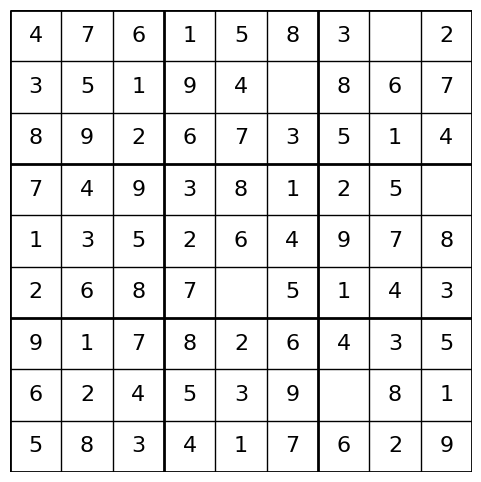

In [ ]:
obs, inf = test_env.reset()
test_env.render()

721 True -1


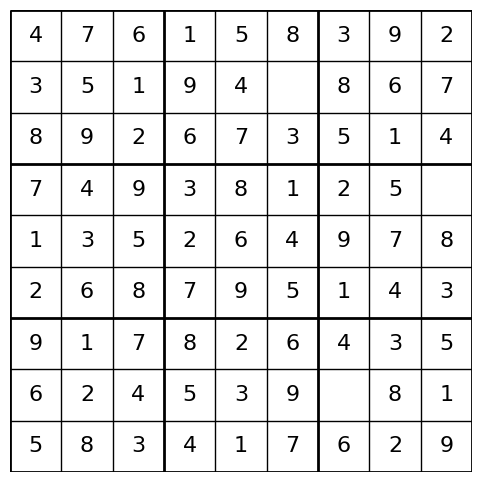

In [ ]:
qs = pi(tf.expand_dims(preprocessing(obs), 0))
act = np.argmax(qs)
obs, reward, terminated, _, _ = test_env.step(act)
print(act, terminated, reward)
test_env.render()